In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import random, os, re
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU
from sklearn.metrics import recall_score,f1_score,precision_score

Using TensorFlow backend.


In [3]:
pos_path = 'rt-polaritydata/rt-polarity.pos'
neg_path = 'rt-polaritydata/rt-polarity.neg'

##### Preprocessing each file to remove digits, special characters, etc.,

In [4]:
def preprocess(filename, label):
    line_dict = []
    f = open(label + '.txt', 'w+')
    with open(filename, 'rt', encoding = 'latin-1') as file_open:
        for line in file_open:
            curr_line = line.lower()
            curr_line = re.sub('<.*?>', '', curr_line)
            curr_line = re.sub('<[a-zA-Z]', '', curr_line)
            curr_line = re.sub('[a-zA-Z]>', '', curr_line)
            curr_line = re.sub(r'[^\w\s]', '', curr_line)
            curr_line = re.sub(r'[0-9]', '', curr_line)
            curr_line = re.sub(r'[^\x00-\x7f]', '', curr_line)
            line_dict.append(curr_line)
            f.write(curr_line + '\n')
    return line_dict

In [5]:
pos_dict = preprocess(pos_path, 'positive')
neg_dict = preprocess(neg_path, 'negative')

##### Forming dataframes

In [6]:
p_data = pd.DataFrame(pos_dict, columns = ['Review'])
p_data['Label'] = 1
p_data.head()

,Review,Label
0,the rock is destined to be the st centurys new...,1
1,the gorgeously elaborate continuation of the ...,1
2,effective but tootepid biopic\n,1
3,if you sometimes like to go to the movies to h...,1
4,emerges as something rare an issue movie that...,1


In [7]:
n_data = pd.DataFrame(neg_dict, columns = ['Review'])
n_data['Label'] = 0
n_data.head()

,Review,Label
0,simplistic silly and tedious \n,0
1,its so laddish and juvenile only teenage boys...,0
2,exploitative and largely devoid of the depth o...,0
3,garbus discards the potential for pathological...,0
4,a visually flashy but narratively opaque and e...,0


##### Concatenating positive and negative dataframes

In [8]:
reviews = pd.concat([p_data, n_data], ignore_index=True)
reviews.head()

,Review,Label
0,the rock is destined to be the st centurys new...,1
1,the gorgeously elaborate continuation of the ...,1
2,effective but tootepid biopic\n,1
3,if you sometimes like to go to the movies to h...,1
4,emerges as something rare an issue movie that...,1


##### Forming vocabulary from reviews dataframe

In [9]:
total_text = []

In [10]:
def vocab(text):
    for s in text['Review']:
        punc_list = set(string.punctuation)
        s = ''.join(c for c in s if c not in punc_list)
        words = [w for w in s.split()]
        total_text.append(words)

In [11]:
vocab(p_data)
vocab(n_data)

In [12]:
print('Vocal Size: ', len(total_text))

Vocal Size:  10662


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_text)
word_index = tokenizer.word_index

In [14]:
# word_index

In [15]:
len(reviews.Label[reviews.Label==0]) / len(reviews.Label[reviews.Label==1]) # checking for class balance

1.0

##### Splitting total data into train and test sets with test set size to be 20% of total data. Stratifying y labels to ensure that the split is class-balanced.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(reviews.Review, reviews.Label, test_size=0.20015, random_state=1, stratify= reviews.Label)

###### Now, splitting the train data into train and dev sets with dev set size to be 20% of total data which is 25% of the previous train data.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify= y_train)

##### Adjusted train test split a bit because 20% of total data is an odd number which was causing class imbalances.

In [18]:
len(y_train)

6396

In [19]:
len(y_test)

2134

In [20]:
len(y_val)

2132

##### Checking class balance in train, test and dev sets after splitting

In [21]:
df = pd.DataFrame(y_train, columns=['Label'])

In [22]:
len(df.Label[df.Label==0]) / len(df.Label[df.Label==1])

1.0

In [23]:
df1 = pd.DataFrame(y_test, columns=['Label'])

In [24]:
len(df1.Label[df1.Label==0]) / len(df1.Label[df1.Label==1])

1.0

In [242]:
df2 = pd.DataFrame(y_val, columns=['Label'])

In [243]:
len(df2.Label[df2.Label==0]) / len(df2.Label[df2.Label==1])

1.0

In [244]:
sequence_length = 48

In [245]:
X_train_sequence = tokenizer.texts_to_sequences(X_train) 
X_val_sequence = tokenizer.texts_to_sequences(X_val) 
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [246]:
# padding to sequence length
X_train_pad = pad_sequences(X_train_sequence, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_sequence, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_sequence, maxlen=sequence_length)

In [28]:
# X_train_pad[0]

#### Word Embeddings

In [29]:
def get_embeddings(wordvector_dimension):
    embeddings_dict = {}
    with open("glove.6B/glove.6B." + str(wordvector_dimension) + "d.txt", "rt", encoding="utf-8") as embed_file:
        for line in embed_file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = coefs
    return embeddings_dict

In [30]:
def get_embedding_matrix(vocab_size, word_index, wordvector_dimension):
    embeddings_dict = get_embeddings(wordvector_dimension)
    embedding_matrix = np.zeros((vocab_size, wordvector_dimension))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

#### Model definitions

In [31]:
def my_rnn(vocab_size, word_index, wordvector_dimension, learning_rate, hidden_units, sequence_length):
    model = Sequential()
    embedding_matrix = get_embedding_matrix(vocab_size, word_index, wordvector_dimension)
    model.add(Embedding(vocab_size, wordvector_dimension, 
                        weights = [embedding_matrix], 
                        input_length= sequence_length, 
                        trainable= False, mask_zero= True))
    model.add(SimpleRNN(units= hidden_units, input_shape= [None, sequence_length], return_sequences= False))
    model.add(Dense(1, activation= 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr= learning_rate)
    model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
    print(model.summary())
    return model

In [32]:
def my_lstm(vocab_size, word_index, wordvector_dimension, learning_rate, hidden_units, sequence_length):
    model = Sequential()
    embedding_matrix = get_embedding_matrix(vocab_size, word_index, wordvector_dimension)
    model.add(Embedding(vocab_size, wordvector_dimension, 
                        weights = [embedding_matrix], 
                        input_length= sequence_length, 
                        trainable= False, mask_zero= True))
    model.add(LSTM(units= hidden_units, input_shape= [None, sequence_length], return_sequences= False))
    model.add(Dense(1, activation= 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr= learning_rate)
    model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
    print(model.summary())
    return model

In [33]:
def my_gru(vocab_size, word_index, wordvector_dimension, learning_rate, hidden_units, sequence_length):
    model = Sequential()
    embedding_matrix = get_embedding_matrix(vocab_size, word_index, wordvector_dimension)
    model.add(Embedding(vocab_size, wordvector_dimension, 
                        weights = [embedding_matrix], 
                        input_length= sequence_length, 
                        trainable= False, mask_zero= True))
    model.add(GRU(units= hidden_units, input_shape= [None, sequence_length], return_sequences= False))
    model.add(Dense(1, activation= 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr= learning_rate)
    model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
    print(model.summary())
    return model

In [34]:
# Plotting accuracy vs loss
def plot_loss_acc(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label = 'Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy']*100, label = 'Validation Accuracy')
    plt.ylim([0, 100])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label = 'Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Validation Loss')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

In [122]:
# setting parameters for models
learning_rate = 0.001
hidden_units = 36
vocab_size = len(word_index) + 1

In [123]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 36)                12132     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 37        
Total params: 6,077,869
Trainable params: 12,169
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [124]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 253us/step - loss: 0.6797 - accuracy: 0.5679 - val_loss: 0.6531 - val_accuracy: 0.6177
Epoch 2/5
6396/6396 [==============================] - 1s 203us/step - loss: 0.5876 - accuracy: 0.6896 - val_loss: 0.5726 - val_accuracy: 0.7125
Epoch 3/5
6396/6396 [==============================] - 1s 202us/step - loss: 0.5175 - accuracy: 0.7473 - val_loss: 0.5455 - val_accuracy: 0.7247
Epoch 4/5
6396/6396 [==============================] - 1s 202us/step - loss: 0.4880 - accuracy: 0.7656 - val_loss: 0.5352 - val_accuracy: 0.7228
Epoch 5/5
6396/6396 [==============================] - 1s 205us/step - loss: 0.4658 - accuracy: 0.7763 - val_loss: 0.5302 - val_accuracy: 0.7336


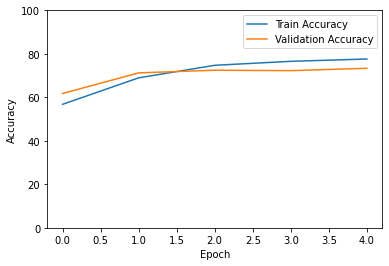

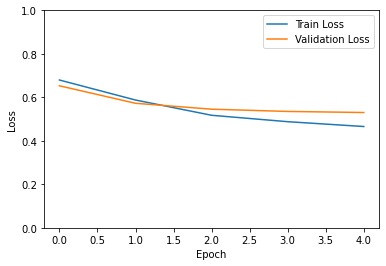

In [125]:
plot_loss_acc(rnn_hist)

#### After experimenting various values for parameters for Vanilla RNN, it was observed that model performed better with 36 hidden units and sequence length of 48 giving training accuracy of ~77.5 and a loss of 0.53.

In [132]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
lstm_9 (LSTM)                (None, 36)                48528     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 37        
Total params: 6,114,265
Trainable params: 48,565
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [133]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 442us/step - loss: 0.6617 - accuracy: 0.6176 - val_loss: 0.6198 - val_accuracy: 0.6750
Epoch 2/5
6396/6396 [==============================] - 2s 355us/step - loss: 0.5521 - accuracy: 0.7297 - val_loss: 0.5394 - val_accuracy: 0.7247
Epoch 3/5
6396/6396 [==============================] - 3s 398us/step - loss: 0.4880 - accuracy: 0.7711 - val_loss: 0.5140 - val_accuracy: 0.7312
Epoch 4/5
6396/6396 [==============================] - 3s 412us/step - loss: 0.4591 - accuracy: 0.7830 - val_loss: 0.5067 - val_accuracy: 0.7453
Epoch 5/5
6396/6396 [==============================] - 2s 379us/step - loss: 0.4461 - accuracy: 0.7907 - val_loss: 0.5302 - val_accuracy: 0.7303


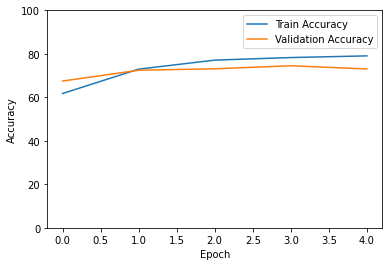

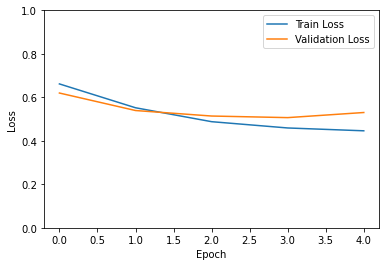

In [134]:
plot_loss_acc(lstm_hist)

In [135]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
gru_9 (GRU)                  (None, 36)                36396     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 37        
Total params: 6,102,133
Trainable params: 36,433
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [136]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 500us/step - loss: 0.6664 - accuracy: 0.5937 - val_loss: 0.6437 - val_accuracy: 0.6309
Epoch 2/5
6396/6396 [==============================] - 3s 443us/step - loss: 0.6001 - accuracy: 0.6779 - val_loss: 0.5925 - val_accuracy: 0.6857
Epoch 3/5
6396/6396 [==============================] - 2s 370us/step - loss: 0.5131 - accuracy: 0.7533 - val_loss: 0.5306 - val_accuracy: 0.7420
Epoch 4/5
6396/6396 [==============================] - 2s 351us/step - loss: 0.4666 - accuracy: 0.7806 - val_loss: 0.5144 - val_accuracy: 0.7439
Epoch 5/5
6396/6396 [==============================] - 2s 346us/step - loss: 0.4407 - accuracy: 0.7924 - val_loss: 0.5095 - val_accuracy: 0.7519


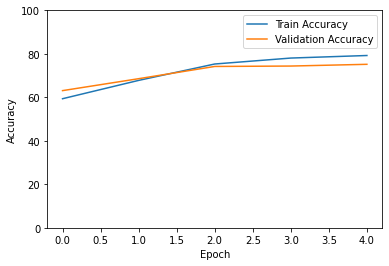

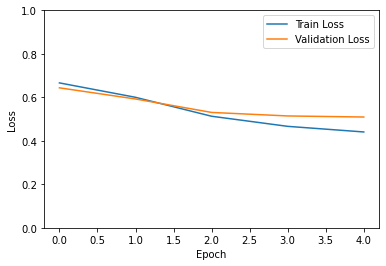

In [137]:
plot_loss_acc(gru_hist)

#### We could observe that, GRU gives better accuracy of ~79% when compared to vanilla RNN and LSTM with 36 hidden units and sequence length of 48

# Experimenting with Network structure

## Doubling the number of hidden units

In [45]:
hidden_units = 72

In [46]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 300)           6065700   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 72)                26856     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 73        
Total params: 6,092,629
Trainable params: 26,929
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [47]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 295us/step - loss: 0.6826 - accuracy: 0.5750 - val_loss: 0.6316 - val_accuracy: 0.6327
Epoch 2/5
6396/6396 [==============================] - 2s 242us/step - loss: 0.5502 - accuracy: 0.7165 - val_loss: 0.5647 - val_accuracy: 0.7078
Epoch 3/5
6396/6396 [==============================] - 2s 241us/step - loss: 0.4859 - accuracy: 0.7661 - val_loss: 0.5546 - val_accuracy: 0.7181
Epoch 4/5
6396/6396 [==============================] - 2s 243us/step - loss: 0.4517 - accuracy: 0.7908 - val_loss: 0.5429 - val_accuracy: 0.7350
Epoch 5/5
6396/6396 [==============================] - 2s 244us/step - loss: 0.4461 - accuracy: 0.7917 - val_loss: 0.5689 - val_accuracy: 0.7106


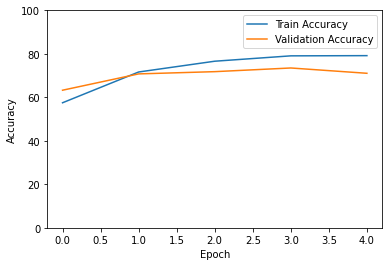

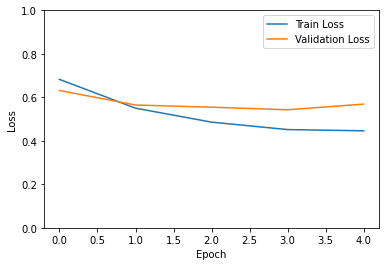

In [48]:
plot_loss_acc(rnn_hist)

In [49]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 300)           6065700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 72)                107424    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 73        
Total params: 6,173,197
Trainable params: 107,497
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [50]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 4s 567us/step - loss: 0.6282 - accuracy: 0.6557 - val_loss: 0.5619 - val_accuracy: 0.7270
Epoch 2/5
6396/6396 [==============================] - 3s 493us/step - loss: 0.5120 - accuracy: 0.7534 - val_loss: 0.5265 - val_accuracy: 0.7331
Epoch 3/5
6396/6396 [==============================] - 3s 495us/step - loss: 0.4703 - accuracy: 0.7730 - val_loss: 0.5282 - val_accuracy: 0.7383
Epoch 4/5
6396/6396 [==============================] - 3s 495us/step - loss: 0.4560 - accuracy: 0.7838 - val_loss: 0.5070 - val_accuracy: 0.7514
Epoch 5/5
6396/6396 [==============================] - 3s 491us/step - loss: 0.4245 - accuracy: 0.8005 - val_loss: 0.5111 - val_accuracy: 0.7519


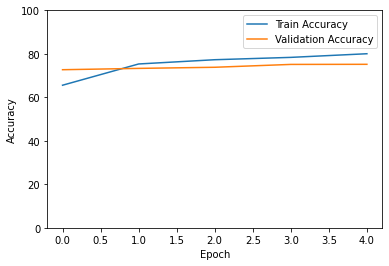

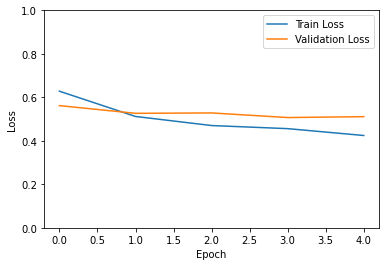

In [51]:
plot_loss_acc(lstm_hist)

In [52]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 48, 300)           6065700   
_________________________________________________________________
gru_2 (GRU)                  (None, 72)                80568     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 73        
Total params: 6,146,341
Trainable params: 80,641
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [53]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 545us/step - loss: 0.6585 - accuracy: 0.6026 - val_loss: 0.6250 - val_accuracy: 0.6501
Epoch 2/5
6396/6396 [==============================] - 3s 463us/step - loss: 0.5590 - accuracy: 0.7139 - val_loss: 0.5533 - val_accuracy: 0.7317
Epoch 3/5
6396/6396 [==============================] - 3s 467us/step - loss: 0.4867 - accuracy: 0.7702 - val_loss: 0.5139 - val_accuracy: 0.7495
Epoch 4/5
6396/6396 [==============================] - 3s 477us/step - loss: 0.4556 - accuracy: 0.7894 - val_loss: 0.5069 - val_accuracy: 0.7514
Epoch 5/5
6396/6396 [==============================] - 3s 461us/step - loss: 0.4308 - accuracy: 0.8010 - val_loss: 0.5034 - val_accuracy: 0.7533


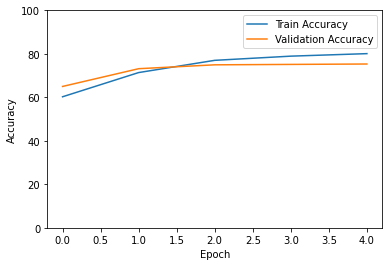

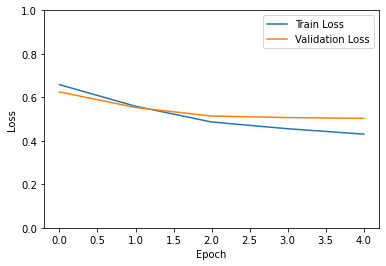

In [54]:
plot_loss_acc(gru_hist)

## Halving the number of hidden units

In [55]:
hidden_units = 18

In [56]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 48, 300)           6065700   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 18)                5742      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 19        
Total params: 6,071,461
Trainable params: 5,761
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [57]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 1s 222us/step - loss: 0.7187 - accuracy: 0.5305 - val_loss: 0.6855 - val_accuracy: 0.5736
Epoch 2/5
6396/6396 [==============================] - 1s 173us/step - loss: 0.6569 - accuracy: 0.6087 - val_loss: 0.6561 - val_accuracy: 0.6008
Epoch 3/5
6396/6396 [==============================] - 1s 174us/step - loss: 0.6136 - accuracy: 0.6637 - val_loss: 0.6149 - val_accuracy: 0.6656
Epoch 4/5
6396/6396 [==============================] - 1s 176us/step - loss: 0.5502 - accuracy: 0.7244 - val_loss: 0.5675 - val_accuracy: 0.7172
Epoch 5/5
6396/6396 [==============================] - 1s 174us/step - loss: 0.5092 - accuracy: 0.7538 - val_loss: 0.5615 - val_accuracy: 0.7223


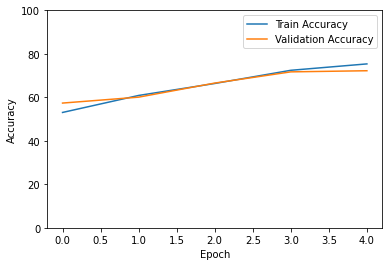

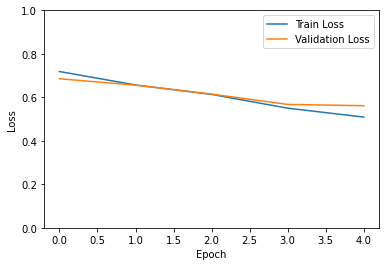

In [58]:
plot_loss_acc(rnn_hist)

In [59]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 300)           6065700   
_________________________________________________________________
lstm_3 (LSTM)                (None, 18)                22968     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 6,088,687
Trainable params: 22,987
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [60]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 318us/step - loss: 0.6740 - accuracy: 0.5916 - val_loss: 0.6447 - val_accuracy: 0.6534
Epoch 2/5
6396/6396 [==============================] - 2s 248us/step - loss: 0.5953 - accuracy: 0.7018 - val_loss: 0.5581 - val_accuracy: 0.7158
Epoch 3/5
6396/6396 [==============================] - 2s 249us/step - loss: 0.5168 - accuracy: 0.7539 - val_loss: 0.5279 - val_accuracy: 0.7322
Epoch 4/5
6396/6396 [==============================] - 2s 256us/step - loss: 0.4804 - accuracy: 0.7756 - val_loss: 0.5141 - val_accuracy: 0.7486
Epoch 5/5
6396/6396 [==============================] - 2s 247us/step - loss: 0.4599 - accuracy: 0.7888 - val_loss: 0.5130 - val_accuracy: 0.7453


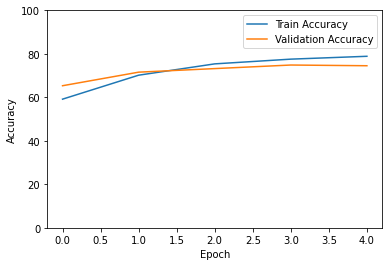

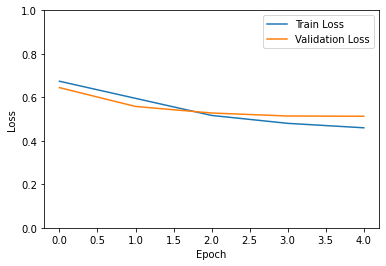

In [61]:
plot_loss_acc(lstm_hist)

In [138]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
gru_10 (GRU)                 (None, 36)                36396     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 37        
Total params: 6,102,133
Trainable params: 36,433
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [139]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 402us/step - loss: 0.6631 - accuracy: 0.5946 - val_loss: 0.6383 - val_accuracy: 0.6435
Epoch 2/5
6396/6396 [==============================] - 2s 331us/step - loss: 0.5933 - accuracy: 0.6859 - val_loss: 0.5841 - val_accuracy: 0.6932
Epoch 3/5
6396/6396 [==============================] - 2s 326us/step - loss: 0.5036 - accuracy: 0.7545 - val_loss: 0.5215 - val_accuracy: 0.7383
Epoch 4/5
6396/6396 [==============================] - 2s 329us/step - loss: 0.4598 - accuracy: 0.7844 - val_loss: 0.5230 - val_accuracy: 0.7491
Epoch 5/5
6396/6396 [==============================] - 2s 325us/step - loss: 0.4458 - accuracy: 0.7936 - val_loss: 0.5149 - val_accuracy: 0.7500


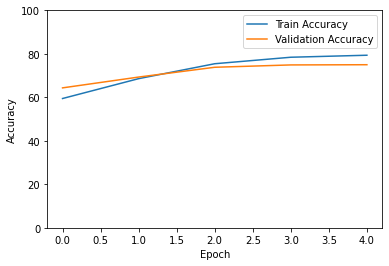

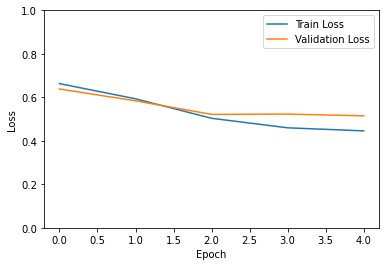

In [140]:
plot_loss_acc(gru_hist)

### Observations:
#### (i) When the number of hidden units were doubled, validation accuracy is greater than training accuracy in the initial epochs but as the epochs increase there is a drop in validation accuracy. This tells that increase in the number of hidden units lead to overfitting.
#### (ii) There is a major change in accuracy when number of hidden units were halved which confirms that there was underfitting.
#### From above, we can conclude and set the optimal number of hidden units to 36.

## Doubling the sequence length

In [65]:
hidden_units = 36
sequence_length = 96

In [66]:
X_train_pad = pad_sequences(X_train_sequence, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_sequence, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_sequence, maxlen=sequence_length)

In [67]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 96, 300)           6065700   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 36)                12132     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 37        
Total params: 6,077,869
Trainable params: 12,169
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [68]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 460us/step - loss: 0.7053 - accuracy: 0.5475 - val_loss: 0.6660 - val_accuracy: 0.6023
Epoch 2/5
6396/6396 [==============================] - 3s 406us/step - loss: 0.6013 - accuracy: 0.6768 - val_loss: 0.6117 - val_accuracy: 0.6740
Epoch 3/5
6396/6396 [==============================] - 3s 407us/step - loss: 0.5280 - accuracy: 0.7416 - val_loss: 0.5684 - val_accuracy: 0.7078
Epoch 4/5
6396/6396 [==============================] - 3s 414us/step - loss: 0.4866 - accuracy: 0.7686 - val_loss: 0.5611 - val_accuracy: 0.7134
Epoch 5/5
6396/6396 [==============================] - 3s 412us/step - loss: 0.4672 - accuracy: 0.7817 - val_loss: 0.5465 - val_accuracy: 0.7237


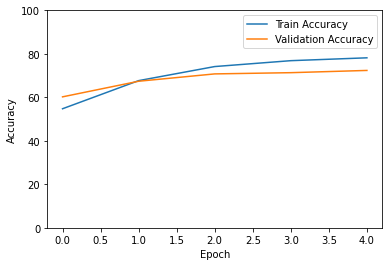

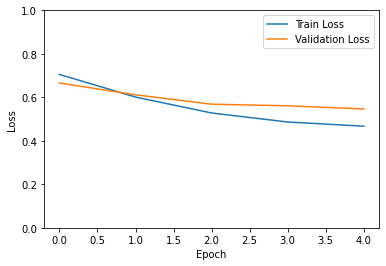

In [69]:
plot_loss_acc(rnn_hist)

In [70]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 96, 300)           6065700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 36)                48528     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 37        
Total params: 6,114,265
Trainable params: 48,565
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [71]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 5s 821us/step - loss: 0.6600 - accuracy: 0.6146 - val_loss: 0.6224 - val_accuracy: 0.6745
Epoch 2/5
6396/6396 [==============================] - 5s 776us/step - loss: 0.5591 - accuracy: 0.7256 - val_loss: 0.5413 - val_accuracy: 0.7209
Epoch 3/5
6396/6396 [==============================] - 5s 820us/step - loss: 0.4937 - accuracy: 0.7647 - val_loss: 0.5156 - val_accuracy: 0.7345
Epoch 4/5
6396/6396 [==============================] - 5s 806us/step - loss: 0.4628 - accuracy: 0.7827 - val_loss: 0.5075 - val_accuracy: 0.7416
Epoch 5/5
6396/6396 [==============================] - 5s 794us/step - loss: 0.4416 - accuracy: 0.7949 - val_loss: 0.5084 - val_accuracy: 0.7477


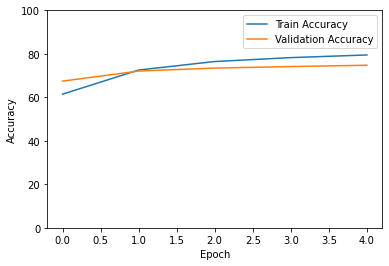

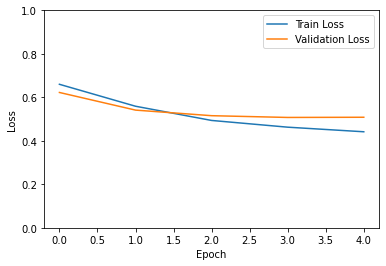

In [72]:
plot_loss_acc(lstm_hist)

In [141]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
gru_11 (GRU)                 (None, 36)                36396     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 37        
Total params: 6,102,133
Trainable params: 36,433
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [142]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 403us/step - loss: 0.6703 - accuracy: 0.5854 - val_loss: 0.6506 - val_accuracy: 0.6220
Epoch 2/5
6396/6396 [==============================] - 2s 331us/step - loss: 0.6063 - accuracy: 0.6775 - val_loss: 0.6054 - val_accuracy: 0.6707
Epoch 3/5
6396/6396 [==============================] - 2s 328us/step - loss: 0.5281 - accuracy: 0.7376 - val_loss: 0.5459 - val_accuracy: 0.7214
Epoch 4/5
6396/6396 [==============================] - 2s 326us/step - loss: 0.4708 - accuracy: 0.7753 - val_loss: 0.5247 - val_accuracy: 0.7326
Epoch 5/5
6396/6396 [==============================] - 2s 330us/step - loss: 0.4446 - accuracy: 0.7955 - val_loss: 0.5140 - val_accuracy: 0.7500


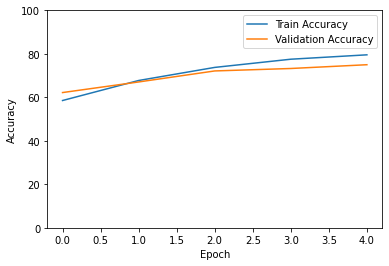

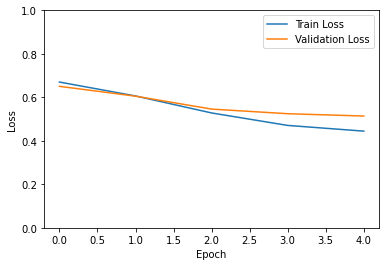

In [143]:
plot_loss_acc(gru_hist)

## Halving the sequence length

In [76]:
sequence_length = 24

In [77]:
X_train_pad = pad_sequences(X_train_sequence, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_sequence, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_sequence, maxlen=sequence_length)

In [78]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 24, 300)           6065700   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 36)                12132     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 37        
Total params: 6,077,869
Trainable params: 12,169
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [79]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 1s 153us/step - loss: 0.6817 - accuracy: 0.5772 - val_loss: 0.6417 - val_accuracy: 0.6262
Epoch 2/5
6396/6396 [==============================] - 1s 107us/step - loss: 0.5681 - accuracy: 0.7042 - val_loss: 0.5866 - val_accuracy: 0.6989
Epoch 3/5
6396/6396 [==============================] - 1s 105us/step - loss: 0.5129 - accuracy: 0.7475 - val_loss: 0.5771 - val_accuracy: 0.7059
Epoch 4/5
6396/6396 [==============================] - 1s 107us/step - loss: 0.4866 - accuracy: 0.7669 - val_loss: 0.5602 - val_accuracy: 0.7153
Epoch 5/5
6396/6396 [==============================] - 1s 107us/step - loss: 0.4648 - accuracy: 0.7814 - val_loss: 0.5598 - val_accuracy: 0.7139


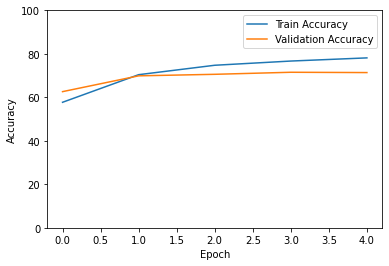

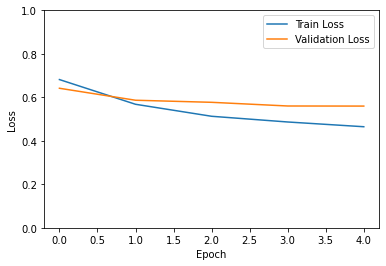

In [80]:
plot_loss_acc(rnn_hist)

In [144]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
lstm_10 (LSTM)               (None, 36)                48528     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 37        
Total params: 6,114,265
Trainable params: 48,565
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [145]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 456us/step - loss: 0.6595 - accuracy: 0.6138 - val_loss: 0.6140 - val_accuracy: 0.6806
Epoch 2/5
6396/6396 [==============================] - 2s 388us/step - loss: 0.5523 - accuracy: 0.7284 - val_loss: 0.5389 - val_accuracy: 0.7294
Epoch 3/5
6396/6396 [==============================] - 2s 374us/step - loss: 0.5002 - accuracy: 0.7577 - val_loss: 0.5152 - val_accuracy: 0.7462
Epoch 4/5
6396/6396 [==============================] - 2s 369us/step - loss: 0.4670 - accuracy: 0.7735 - val_loss: 0.5066 - val_accuracy: 0.7472
Epoch 5/5
6396/6396 [==============================] - 2s 360us/step - loss: 0.4466 - accuracy: 0.7900 - val_loss: 0.5005 - val_accuracy: 0.7495


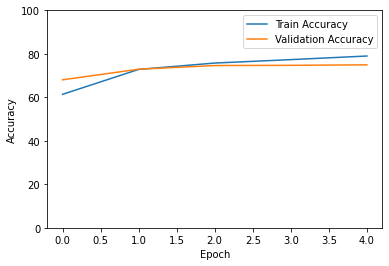

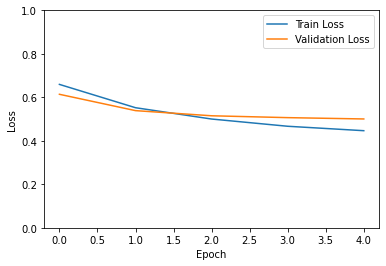

In [146]:
plot_loss_acc(lstm_hist)

In [150]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
gru_13 (GRU)                 (None, 36)                36396     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 37        
Total params: 6,102,133
Trainable params: 36,433
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [151]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 419us/step - loss: 0.6610 - accuracy: 0.6055 - val_loss: 0.6408 - val_accuracy: 0.6327
Epoch 2/5
6396/6396 [==============================] - 2s 351us/step - loss: 0.5986 - accuracy: 0.6836 - val_loss: 0.5828 - val_accuracy: 0.6937
Epoch 3/5
6396/6396 [==============================] - 2s 348us/step - loss: 0.5062 - accuracy: 0.7523 - val_loss: 0.5251 - val_accuracy: 0.7369
Epoch 4/5
6396/6396 [==============================] - 2s 338us/step - loss: 0.4634 - accuracy: 0.7778 - val_loss: 0.5343 - val_accuracy: 0.7406
Epoch 5/5
6396/6396 [==============================] - 2s 338us/step - loss: 0.4480 - accuracy: 0.7921 - val_loss: 0.5113 - val_accuracy: 0.7373


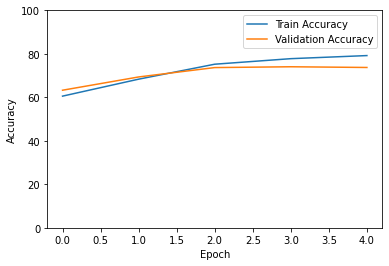

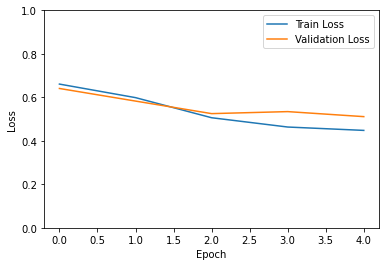

In [152]:
plot_loss_acc(gru_hist)

### Observations:
#### (i) Doubling and halving the sequence length doesn't reflect much change in loss, the reason being padding which normalizes the sequence length.
#### (ii) Though halving the sequence length might increase the accuracy a little which says that initial words of review play a crucial in classifying a review but there will be an increase in loss as epochs increase.
#### From above, we can conclude and set sequence length to 48.

## Using 50d word embedding

In [87]:
hidden_units = 36
sequence_length = 48

In [88]:
X_train_pad = pad_sequences(X_train_sequence, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_sequence, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_sequence, maxlen=sequence_length)

In [89]:
rnnmodel = my_rnn(vocab_size, word_index, 50, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 48, 50)            1010950   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 36)                3132      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 37        
Total params: 1,014,119
Trainable params: 3,169
Non-trainable params: 1,010,950
_________________________________________________________________
None


In [90]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 1s 150us/step - loss: 0.7297 - accuracy: 0.5077 - val_loss: 0.7181 - val_accuracy: 0.5066
Epoch 2/5
6396/6396 [==============================] - 1s 102us/step - loss: 0.6802 - accuracy: 0.5721 - val_loss: 0.6925 - val_accuracy: 0.5474
Epoch 3/5
6396/6396 [==============================] - 1s 100us/step - loss: 0.6586 - accuracy: 0.6026 - val_loss: 0.6795 - val_accuracy: 0.5680
Epoch 4/5
6396/6396 [==============================] - 1s 96us/step - loss: 0.6399 - accuracy: 0.6270 - val_loss: 0.6623 - val_accuracy: 0.6008
Epoch 5/5
6396/6396 [==============================] - 1s 99us/step - loss: 0.6122 - accuracy: 0.6696 - val_loss: 0.6313 - val_accuracy: 0.6454


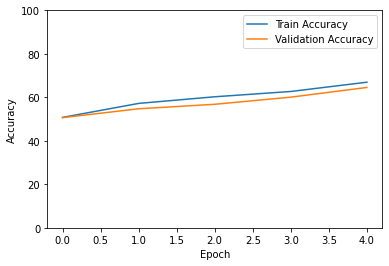

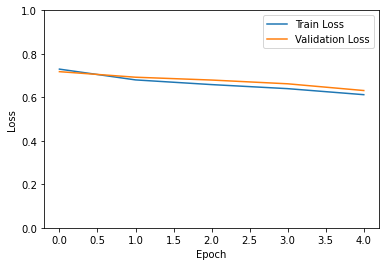

In [91]:
plot_loss_acc(rnn_hist)

In [153]:
lstmmodel = my_lstm(vocab_size, word_index, 50, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 48, 50)            1010950   
_________________________________________________________________
lstm_11 (LSTM)               (None, 36)                12528     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 37        
Total params: 1,023,515
Trainable params: 12,565
Non-trainable params: 1,010,950
_________________________________________________________________
None


In [154]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 320us/step - loss: 0.6766 - accuracy: 0.5802 - val_loss: 0.6586 - val_accuracy: 0.6243
Epoch 2/5
6396/6396 [==============================] - 2s 244us/step - loss: 0.6377 - accuracy: 0.6437 - val_loss: 0.6215 - val_accuracy: 0.6534
Epoch 3/5
6396/6396 [==============================] - 2s 248us/step - loss: 0.5978 - accuracy: 0.6846 - val_loss: 0.6013 - val_accuracy: 0.6796
Epoch 4/5
6396/6396 [==============================] - 2s 255us/step - loss: 0.5740 - accuracy: 0.7101 - val_loss: 0.5918 - val_accuracy: 0.6829
Epoch 5/5
6396/6396 [==============================] - 2s 254us/step - loss: 0.5581 - accuracy: 0.7148 - val_loss: 0.5766 - val_accuracy: 0.7078


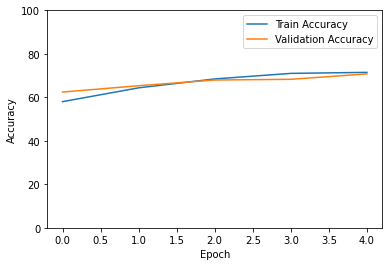

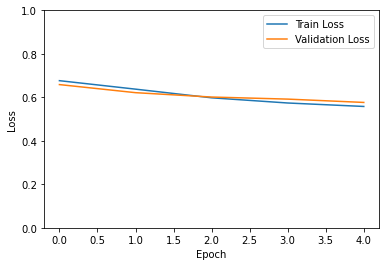

In [155]:
plot_loss_acc(lstm_hist)

In [95]:
grumodel = my_gru(vocab_size, word_index, 50, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 48, 50)            1010950   
_________________________________________________________________
gru_6 (GRU)                  (None, 36)                9396      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 37        
Total params: 1,020,383
Trainable params: 9,433
Non-trainable params: 1,010,950
_________________________________________________________________
None


In [96]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 318us/step - loss: 0.6845 - accuracy: 0.5467 - val_loss: 0.6752 - val_accuracy: 0.5732
Epoch 2/5
6396/6396 [==============================] - 1s 219us/step - loss: 0.6584 - accuracy: 0.6118 - val_loss: 0.6599 - val_accuracy: 0.6018
Epoch 3/5
6396/6396 [==============================] - 1s 220us/step - loss: 0.6374 - accuracy: 0.6366 - val_loss: 0.6420 - val_accuracy: 0.6384
Epoch 4/5
6396/6396 [==============================] - 1s 218us/step - loss: 0.6026 - accuracy: 0.6793 - val_loss: 0.5989 - val_accuracy: 0.6745
Epoch 5/5
6396/6396 [==============================] - 1s 222us/step - loss: 0.5625 - accuracy: 0.7178 - val_loss: 0.5864 - val_accuracy: 0.6876


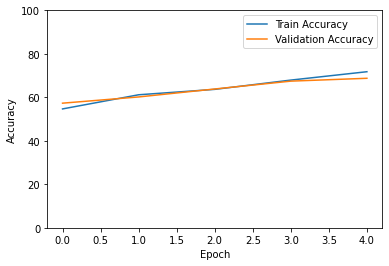

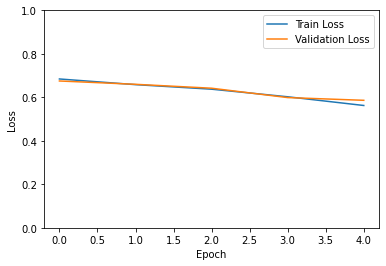

In [97]:
plot_loss_acc(gru_hist)

##### We can see that when word embedding of 50d for one word was used there is a drop in accuracy because it is known that higher dimensional matrix better represent the word and hence validaiton accuracy might increase as the dimension of word embeddings increase. 

## Best Model Evaluation

### RNN

In [220]:
hidden_units = 36
sequence_length = 48

In [221]:
X_train_pad = pad_sequences(X_train_sequence, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_sequence, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_sequence, maxlen=sequence_length)

In [222]:
rnnmodel = my_rnn(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 36)                12132     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 37        
Total params: 6,077,869
Trainable params: 12,169
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [223]:
rnn_hist = rnnmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 2s 247us/step - loss: 0.7065 - accuracy: 0.5399 - val_loss: 0.6791 - val_accuracy: 0.5680
Epoch 2/5
6396/6396 [==============================] - 1s 198us/step - loss: 0.6367 - accuracy: 0.6331 - val_loss: 0.6409 - val_accuracy: 0.6257
Epoch 3/5
6396/6396 [==============================] - 1s 199us/step - loss: 0.5664 - accuracy: 0.7087 - val_loss: 0.5698 - val_accuracy: 0.7233
Epoch 4/5
6396/6396 [==============================] - 1s 199us/step - loss: 0.5050 - accuracy: 0.7548 - val_loss: 0.5532 - val_accuracy: 0.7256
Epoch 5/5
6396/6396 [==============================] - 1s 198us/step - loss: 0.4751 - accuracy: 0.7725 - val_loss: 0.5498 - val_accuracy: 0.7270


In [224]:
rnn_predict = rnnmodel.predict_classes(np.array(X_test_pad))

In [225]:
rnn_precision = precision_score(np.asarray(y_test),rnn_predict,average='binary')
rnn_recall = recall_score(np.asarray(y_test), rnn_predict, average='binary')
rnn_f1 = f1_score(np.asarray(y_test),rnn_predict,average='binary')

In [226]:
print('Precision: ', rnn_precision)
print('Recall: ', rnn_recall)
print('F1-measure: ', rnn_f1)

Precision:  0.7335190343546889
Recall:  0.7403936269915652
F1-measure:  0.7369402985074627


### LSTM

In [232]:
lstmmodel = my_lstm(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
lstm_15 (LSTM)               (None, 36)                48528     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 37        
Total params: 6,114,265
Trainable params: 48,565
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [233]:
lstm_hist = lstmmodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 431us/step - loss: 0.6601 - accuracy: 0.6149 - val_loss: 0.6206 - val_accuracy: 0.6731
Epoch 2/5
6396/6396 [==============================] - 2s 355us/step - loss: 0.5553 - accuracy: 0.7242 - val_loss: 0.5457 - val_accuracy: 0.7242
Epoch 3/5
6396/6396 [==============================] - 2s 351us/step - loss: 0.4932 - accuracy: 0.7664 - val_loss: 0.5206 - val_accuracy: 0.7383
Epoch 4/5
6396/6396 [==============================] - 2s 359us/step - loss: 0.4658 - accuracy: 0.7785 - val_loss: 0.5195 - val_accuracy: 0.7402
Epoch 5/5
6396/6396 [==============================] - 2s 360us/step - loss: 0.4459 - accuracy: 0.7892 - val_loss: 0.5202 - val_accuracy: 0.7472


In [234]:
lstm_predict = lstmmodel.predict_classes(np.array(X_test_pad))

In [235]:
lstm_precision = precision_score(np.asarray(y_test), lstm_predict, average='binary')
lstm_recall = recall_score(np.asarray(y_test), lstm_predict, average='binary')
lstm_f1 = f1_score(np.asarray(y_test), lstm_predict,average='binary')

In [236]:
print('Precision: ', lstm_precision)
print('Recall: ', lstm_recall)
print('F1-measure: ', lstm_f1)

Precision:  0.7422222222222222
Recall:  0.7825679475164011
F1-measure:  0.7618613138686131


### GRU

In [237]:
grumodel = my_gru(vocab_size, word_index, 300, learning_rate, 
                     hidden_units, sequence_length)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 48, 300)           6065700   
_________________________________________________________________
gru_17 (GRU)                 (None, 36)                36396     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 37        
Total params: 6,102,133
Trainable params: 36,433
Non-trainable params: 6,065,700
_________________________________________________________________
None


In [238]:
gru_hist = grumodel.fit(np.array(X_train_pad), np.array(y_train), 
                           epochs= 5, batch_size= 300, 
                           validation_data=(np.array(X_val_pad), np.array(y_val)))

Train on 6396 samples, validate on 2132 samples
Epoch 1/5
6396/6396 [==============================] - 3s 464us/step - loss: 0.6782 - accuracy: 0.5732 - val_loss: 0.6500 - val_accuracy: 0.6257
Epoch 2/5
6396/6396 [==============================] - 2s 337us/step - loss: 0.6126 - accuracy: 0.6710 - val_loss: 0.6069 - val_accuracy: 0.6721
Epoch 3/5
6396/6396 [==============================] - 2s 331us/step - loss: 0.5313 - accuracy: 0.7395 - val_loss: 0.5347 - val_accuracy: 0.7369
Epoch 4/5
6396/6396 [==============================] - 2s 351us/step - loss: 0.4697 - accuracy: 0.7760 - val_loss: 0.5184 - val_accuracy: 0.7430
Epoch 5/5
6396/6396 [==============================] - 2s 348us/step - loss: 0.4464 - accuracy: 0.7933 - val_loss: 0.5115 - val_accuracy: 0.7439


In [239]:
gru_predict = grumodel.predict_classes(np.array(X_test_pad))

In [240]:
gru_precision = precision_score(np.asarray(y_test), gru_predict, average= 'binary')
gru_recall = recall_score(np.asarray(y_test), gru_predict, average= 'binary')
gru_f1 = f1_score(np.asarray(y_test), gru_predict, average= 'binary')

In [241]:
print('Precision: ', gru_precision)
print('Recall: ', gru_recall)
print('F1-measure: ', gru_f1)

Precision:  0.7810590631364562
Recall:  0.7188378631677601
F1-measure:  0.7486578818936067


## Complete analysis of models

#### (i) F1 score is the harmonic mean of precision and recall, used when there is uneven class distribution. But, here we have even class distribution which means F1 is not that important measure.
#### (ii) All the measures for all the models are almost similar except for Recall. LSTM has higher recall when comapred to the other two which means it has less false negatives and LSTM can be used when the outcome of a review is very important.
#### (iii) GRU is the best model for this dataset with slightly higher accuracy of ~79% and would increase as dimensions of word embedding matrix increases.